# Explore text of enwiki SQL dump .sql files
(uncollapse for detailed code)

## setup

### libraries

In [90]:
import pandas as pd
import matplotlib.pyplot as plt
from file_read_backwards import FileReadBackwards

### paths

In [69]:
dir_path = '../data/raw/enwiki/'
category_path = '../data/raw/enwiki/enwiki-latest-category.sql'
page_path = '../data/raw/enwiki/enwiki-latest-page.sql'
categorylinks_path = '../data/raw/enwiki/enwiki-latest-categorylinks.sql'
paths = [category_path, page_path, categorylinks_path]
filenames = [path.split(sep='/')[-1] for path in paths]

### functions

#### function to open a dumpfile

In [110]:
def open_dump(url):
    """
    Open a mysql dumpfile for reading its text.
    """
    return open(url, mode='r', encoding='UTF_8', errors='backslashreplace')

#### function to get lengths of each line in the sql files

In [116]:
def get_line_lengths(path:str, encoding:str='UTF_8', errors='backslashreplace', mode='r') -> pd.Series:
    """
    Get line lengths from a potentially-large text file.
    Input:  filepath of text file
    Output: pd.Series of integer line-lengths,
                index is line-number
    """
    
    d = {}
    i = 0
    
    with open(
        path, 
        mode=mode, 
        encoding=encoding, 
        errors=errors
    ) as f:
        while (x := f.readline()):
            d[i] = len(x)
            i += 1

    return pd.Series(d, name='line_lengths')

#### function read_footer

In [112]:
def read_footer(path):
    """
    Leverage the module: 'file_read_backwards' to read the last lines of
        a dumpfile, up until the lines are longer than 200 chars.
    """
    lines = []
    with FileReadBackwards(path, encoding='utf-8') as frb:
        while len(l := frb.readline()) < 200 :
            if not l:
                break
            lines.append(l)
    return list(reversed(lines))

## check line lengths

#### store line-length series for each file in a dict

In [117]:
dict_of_length_series = {}
for filename, path in zip(filenames, paths):
    dict_of_length_series[filename] = get_line_lengths(path)

#### generate tables

##### line counts

In [56]:
line_counts = pd.concat(
    (pd.Series({i: len(dict_of_length_series[i])}) for i in dict_of_length_series),
    axis = 0
).rename('line counts').to_frame()
line_counts

,line counts
enwiki-latest-category.sql,164
enwiki-latest-page.sql,6471
enwiki-latest-categorylinks.sql,24429


##### first few line lengths

In [57]:
head = pd.concat(
    (dict_of_length_series[i].head(45).rename(i).to_frame() for i in dict_of_length_series),
    axis = 1
).T.rename_axis('line-lengths')
head

,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,45
line-lengths,,,,,,,,,,,,,,,,,,,,,
enwiki-latest-category.sql,76,3,41,58,38,1,66,68,66,31,...,1,3,37,3,1,49,1016485,1020907,1022071,1021962
enwiki-latest-page.sql,76,3,41,58,38,1,66,68,66,31,...,49,51,42,27,64,37,31,85,86,57
enwiki-latest-categorylinks.sql,76,3,41,58,38,1,66,68,66,31,...,70,62,57,1,3,42,3,1,54,1106336


##### last few line lengths

In [58]:
tail = pd.concat(
    (dict_of_length_series[i].tail(45).reset_index(drop=True).rename(i).to_frame() for i in dict_of_length_series),
    axis=1
)
tail.index = range(-45,0)
tail = tail.T.rename_axis('line-lengths')
tail

,-45,-44,-43,-42,-41,-40,-39,-38,-37,-36,...,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
line-lengths,,,,,,,,,,,,,,,,,,,,,
enwiki-latest-category.sql,1026192,1026203,1025312,1025496,1026336,1017999,1026331,1027685,1025438,1026809,...,1,40,60,50,64,66,64,42,1,41
enwiki-latest-page.sql,1036239,1037387,1037318,1037146,1037498,1037314,1038536,1037706,1038308,1038421,...,1,40,60,50,64,66,64,42,1,41
enwiki-latest-categorylinks.sql,1121145,1124708,1123446,1123851,1121403,1121555,1113303,1120170,1119324,1123942,...,1,40,60,50,64,66,64,42,1,41


#### generate plots

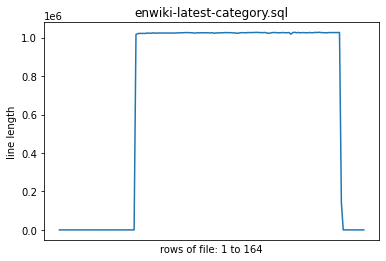

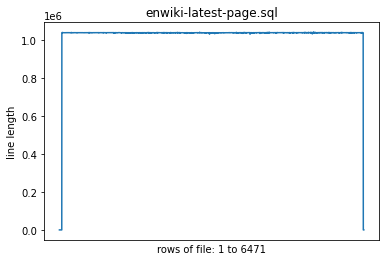

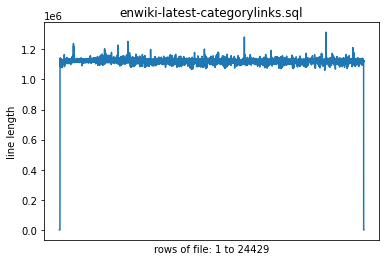

In [53]:
figs = {}; axes = {}
for i in filenames:
    figs[i] = plt.figure()
    axes[i] = figs[i].gca()
    dict_of_length_series[i].plot(ax=axes[i])
    axes[i].set_xticks([])
    axes[i].set_xlabel(f'rows of file: 1 to {len(dict_of_length_series[i])}')
    axes[i].set_ylabel('line length')
    axes[i].set_title(i)
    plt.show()

## peek at text of dumpfiles

#### get ```start_insert_nums``` and ```start_footer_nums``` from line lengths

In [127]:
def get_first(lambda_boolean_condition:str, ser:pd.Series):
    """
    WARNING: USES pd.Series.eval()
    Returns index of the first element of a pd.Series that satisfies a lambda boolean condition
    Inputs:
        lambda_boolean_condition (str): lambda boolean condition as string
        ser (pd.Series): series to to find the first of
    """
    for i in ser.index:
        try:
            if ser.eval(condition):
                return i
            else:
                continue
        except:
            continue

In [140]:
start_insert_nums = {}
start_footer_nums = {}
for i in filenames:
    insert_indices = dict_of_length_series[i].to_frame().query('line_lengths > 200').index
    start_insert_nums[i] = insert_indices[0]
    start_footer_nums[i] = insert_indices[-1] + 1

In [144]:
dict_header_rows, dict_footer_rows = {}, {}
for name in filenames:
    with open_dump(dir_path + name) as f:
        header_rows, footer_rows = [], []
        ct = 0
        while ct < start_insert_nums[name]:
            header_rows.append(f.readline())
            ct += 1
        while ct < start_footer_nums[name]:
            f.readline()
            ct += 1
        while (line := f.readline()):
            footer_rows.append(f.readline())
        dict_header_rows[name] = header_rows
        dict_footer_rows[name] = footer_rows

KeyboardInterrupt: 

In [89]:
print('\n'.join(dict_header_rows[filenames[0]]))

-- MySQL dump 10.19  Distrib 10.3.31-MariaDB, for debian-linux-gnu (x86_64)

--

-- Host: 10.64.48.13    Database: enwiki

-- ------------------------------------------------------

-- Server version	10.4.21-MariaDB-log



/*!40101 SET @OLD_CHARACTER_SET_CLIENT=@@CHARACTER_SET_CLIENT */;

/*!40101 SET @OLD_CHARACTER_SET_RESULTS=@@CHARACTER_SET_RESULTS */;

/*!40101 SET @OLD_COLLATION_CONNECTION=@@COLLATION_CONNECTION */;

/*!40101 SET NAMES utf8mb4 */;

/*!40103 SET @OLD_TIME_ZONE=@@TIME_ZONE */;

/*!40103 SET TIME_ZONE='+00:00' */;

/*!40014 SET @OLD_UNIQUE_CHECKS=@@UNIQUE_CHECKS, UNIQUE_CHECKS=0 */;

/*!40014 SET @OLD_FOREIGN_KEY_CHECKS=@@FOREIGN_KEY_CHECKS, FOREIGN_KEY_CHECKS=0 */;

/*!40101 SET @OLD_SQL_MODE=@@SQL_MODE, SQL_MODE='NO_AUTO_VALUE_ON_ZERO' */;

/*!40111 SET @OLD_SQL_NOTES=@@SQL_NOTES, SQL_NOTES=0 */;



--

-- Table structure for table `category`

--



DROP TABLE IF EXISTS `category`;

/*!40101 SET @saved_cs_client     = @@character_set_client */;

/*!40101 SET charac

In [ ]:
print('\n'.join(footer_rows))

### peek at headers

### peek at footers

### peek at an interior row

#### get first 240 characters of line 60 in each dumpfile

In [81]:
line_num = 60
dict_line60 = {}
for i in filenames:
    with open_dump(dir_path + i) as f:
        for j in range(line_num):
            f.readline()
        dict_line60[i] = [f.readline()[:80], f.readline()[80:160], f.readline()[160:240]]

#### print the first 240 characters of line 60 of each dumpfile

In [82]:
for name in filenames:
    print(name)
    print('\n\t'.join(dict_line60[name]))
    print()

enwiki-latest-category.sql
INSERT INTO `category` VALUES (773529,'People_from_Fort_Worth',0,0,0),(773531,'C
	1,0),(824007,'Pequot_War',27,0,0),(824009,'Cities_and_towns_in_Fatehgarh_Sahib_d
	lms',0,0,0),(6585460,'B-Class_Saint_Lucia_articles',3,0,0),(6585574,'Subgroup_se

enwiki-latest-page.sql
INSERT INTO `page` VALUES (101540,1,'Susquehanna_County,_Pennsylvania','',0,0,0.
	,'20211029153637','20211029183623',973939179,12667,'wikitext',NULL),(110842,0,'N
	ikitext',NULL),(119449,0,'Lammers_Township,_Beltrami_County,_Minnesota','',0,0,0

enwiki-latest-categorylinks.sql
INSERT INTO `categorylinks` VALUES (9701,'Wikipedia_Version_1.0_articles','2LFN:
	 03:01:42',' ','uca-default-u-kn','page'),(10191,'Edo_period','20F\xdc','201
	3,'CS1_German-language_sources_(de)','8:NPFLZF44:@B\xdc','2021-04-20 13:57



# TL;DR

### Summary of file structure

- **Headers and schema:**
    - from beginning of file to approx 41st row
- **Data:**
    - formatted as sql INSERT commands
    - each INSERT row has ~10^6 characters
    - until the footers
- **Footers:**
    - some footers

## display tables and plots

#### display tables of line-counts, line-lengths

In [46]:
display(line_counts, head, tail)

,line counts
enwiki-latest-category.sql,164
enwiki-latest-page.sql,6471
enwiki-latest-categorylinks.sql,24429


,1,2,3,4,5,6,7,8,9,10,...,36,37,38,39,40,41,42,43,44,45
line-lengths,,,,,,,,,,,,,,,,,,,,,
enwiki-latest-category.sql,76,3,41,58,38,1,66,68,66,31,...,1,3,37,3,1,49,1016485,1020907,1022071,1021962
enwiki-latest-page.sql,76,3,41,58,38,1,66,68,66,31,...,49,51,42,27,64,37,31,85,86,57
enwiki-latest-categorylinks.sql,76,3,41,58,38,1,66,68,66,31,...,70,62,57,1,3,42,3,1,54,1106336


,-45,-44,-43,-42,-41,-40,-39,-38,-37,-36,...,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1
enwiki-latest-category.sql,1026192,1026203,1025312,1025496,1026336,1017999,1026331,1027685,1025438,1026809,...,1,40,60,50,64,66,64,42,1,41
enwiki-latest-page.sql,1036239,1037387,1037318,1037146,1037498,1037314,1038536,1037706,1038308,1038421,...,1,40,60,50,64,66,64,42,1,41
enwiki-latest-categorylinks.sql,1121145,1124708,1123446,1123851,1121403,1121555,1113303,1120170,1119324,1123942,...,1,40,60,50,64,66,64,42,1,41


#### display plots of the line lengths

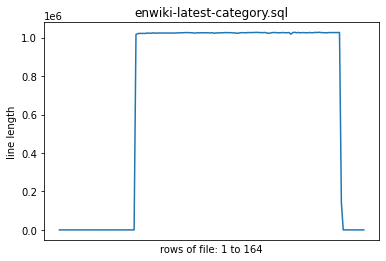

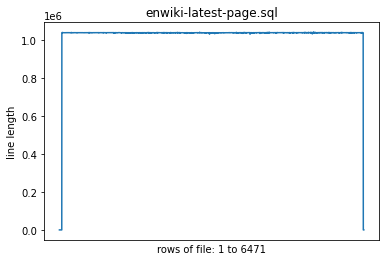

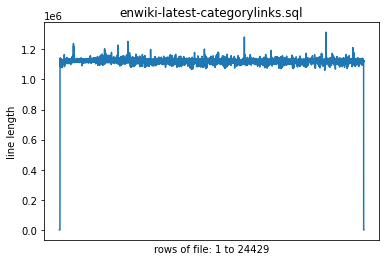

In [64]:
for i in figs: display(figs[i])